### Melanoma and tumor-infiltrating lymphocyte examples

This notebook prepares Perturb-seq datasets from [Frangieh et al.](https://www.nature.com/articles/s41588-021-00779-1), a project on melanoma immune checkpoint inhibitor resistance. CRISPR knockouts of ~250 genes were applied to melanoma cells, and then the melanoma cells were treated in a variety of ways, including control, interferon gamma, and co-culture with tumor infiltrating lymphocytes. The idea is to see what mutations in melanoma might protect the melanoma from the lymphocytes. The paper included low-dimensional readouts based on melanoma survival and also perturb-seq readouts, which included mostly melanoma with minimal T cell contamination. 

Here we tidy the dataset and carry out a simple exploration in scanpy.

In [105]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import sys
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import scipy as sp
from scipy.stats import spearmanr as spearmanr
from scipy.stats import pearsonr
import itertools as it
import anndata

import functools
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.oneway import anova_oneway
from sklearn.metrics import mutual_info_score
import time
from collections import Counter


# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/gary/cahan_rotation/perturbation_data")

# Universal
geneAnnotationPath = "setup/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath = "setup/tfList.csv"                                 # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "setup/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellCyclePath= "setup/regev_lab_cell_cycle_genes.txt"

# Nakatake Specific
rawDataPath  = "not_ready/frangieh/RNA_expression.csv.gz"
rawH5ADPath  = "not_ready/frangieh/RNA_expression.h5ad.gz"
cellMetaPath = "not_ready/frangieh/all_sgRNA_assignments.txt"   
cellConditionPath = "not_ready/frangieh/RNA_metadata.csv"
perturbEffectTFOnlyPath = "setup/frangiehTFOnly.csv"                        # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/frangiehFullTranscriptome.csv"  # a path to store temp file

finalDataFileFolder = "perturbations/frangieh"
finalDataFilePath   = "perturbations/frangieh/test.h5ad"

### Load expression data & set up cell metadata

In [66]:
if os.path.exists(rawH5ADPath):
    expression_quantified = sc.read_h5ad(rawH5ADPath)
else:
    expression_quantified = sc.read_csv(rawDataPath)
    expression_quantified.write_h5ad(rawH5ADPath, compression="gzip")

In [67]:
expression_quantified.X = sp.sparse.csr_matrix(expression_quantified.X)
expression_quantified = expression_quantified.T

In [68]:
cell_meta  = pd.read_csv(cellMetaPath)
cell_meta2 = pd.read_csv(cellConditionPath, skiprows=[1])
cell_meta  = cell_meta.merge(cell_meta2, left_on="Cell", right_on="NAME")
cell_meta.index = cell_meta["Cell"].tolist()
expression_quantified.obs = cell_meta
expression_quantified.raw = expression_quantified.copy()

In [69]:
sc.pp.calculate_qc_metrics(expression_quantified, inplace = True)

In [70]:
guides = functools.reduce(lambda a,b: a.union(b), [set(str(s).split(",")) for s in expression_quantified.obs["sgRNAs"]])
def get_target(guide):
    return re.sub("_[0-9]*$", "", guide) 
def is_control(target):
    return "SITE" in target
human_tfs = pd.read_csv(humanTFPath)
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
np.array(list(set([get_target(g) for g in guides]).intersection(human_tfs["HGNC symbol"])))

array(['EEA1', 'TFAP2A', 'IRF4', 'SOX4', 'SP100', 'SMAD4', 'KLF4',
       'STAT1', 'TP53', 'STAT3', 'AEBP1', 'MYC', 'SMAD3', 'IRF3', 'FOXM1',
       'E2F1', 'DNMT1', 'FOS'], dtype='<U6')

### Fill `perturbation` & `Is_control`

In [71]:
expression_quantified.obs["targets"] = [
    ",".join(
                [
                    get_target(g) for g in str(s).split(",") if not is_control(get_target(g))
                ]
        ) 
    for s in expression_quantified.obs["sgRNAs"]
]
expression_quantified.obs["targets"].value_counts(dropna = False)

nan                                23028
                                   16319
IFNGR2                               920
JAK2                                 834
MFGE8                                810
                                   ...  
HLA-H,RNF213,TAPBP,TRIM22              1
EIF3K,TP53                             1
CD47,CDKN1A,KCNN4,LRPAP1,TOP1MT        1
FKBP4,SET,STAT1                        1
IRF3,JAK1                              1
Name: targets, Length: 35363, dtype: int64

In [72]:
expression_quantified.obs["perturbation"] = expression_quantified.obs['targets']
expression_quantified.obs["is_control"]   = [t in {"nan", ""} for t in expression_quantified.obs['targets']]
expression_quantified.obs["is_control_int"]   = expression_quantified.obs["is_control"].astype(int)
expression_quantified.obs["is_control"].value_counts(dropna = False)

False    178984
True      39347
Name: is_control, dtype: int64

### Normalization

In [73]:
expression_quantified.obs["MOI"] = expression_quantified.obs["MOI"].astype(np.int32)
expression_quantified.obs["UMI_count"] = expression_quantified.obs["UMI_count"].astype(np.double)

In [76]:
# de-normalize and round up
norm_factor =  expression_quantified.obs["UMI_count"].values / 1.0e6
Z = sp.sparse.diags(norm_factor).dot(np.expm1(expression_quantified.X))
print(np.greater_equal(np.abs(Z.data - np.rint(Z.data)), 0.01).any())
Z.data = np.rint(Z.data)
expression_quantified.X = Z

False


### QC filters

In [80]:
print("Number of cells: ", expression_quantified.n_obs)
print("Number of genes: ", expression_quantified.n_vars)
sc.pp.filter_cells(expression_quantified, min_genes=500)
sc.pp.filter_genes(expression_quantified, min_cells=500)
print("Number of cells: ", expression_quantified.n_obs)
print("Number of genes: ", expression_quantified.n_vars)

Number of cells:  218331
Number of genes:  23712
Number of cells:  218027
Number of genes:  15335


In [81]:
expression_quantified.layers["counts"] = expression_quantified.X.copy()
sc.pp.normalize_total(expression_quantified, target_sum=1e5)
sc.pp.log1p(expression_quantified)

In [82]:
# Convert NaNs to empty string in the sgRNAs field
expression_quantified.obs.sgRNAs[expression_quantified.obs.sgRNAs.apply(lambda x: not isinstance(x, str) and np.isnan(x))] = ""

In [83]:
# check if the field MOI has some irregularities, such that a truncated guide or a wrong number
ind = []
for index, row in expression_quantified.obs.iterrows():
    flag = False
    if row["sgRNAs"] != "":
        guides = row["sgRNAs"].split(",")
        if len(guides) != row["MOI"]:
            flag = True
        if "_" not in guides[-1]:
            flag = True
    if flag:
        ind += [index]
ind

[]

In [84]:
# check gene sets and ensure matching with measurements
err = 0
ind = []
obs_genes = {}
unfound_genes = {}
targets = []
for index, row in expression_quantified.obs.iterrows():
    current_target = []
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes:
            if gene in expression_quantified.var.index:
                # gene is found
                current_target += [gene]
                if gene not in obs_genes:
                    obs_genes[gene] = 1
                else:
                    obs_genes[gene] += 1
            else:
                if gene not in unfound_genes:
                    unfound_genes[gene] = 1
                else:
                    unfound_genes[gene] += 1
    # end gene list
    targets += [",".join(current_target)]

In [85]:
# create regimes
regimes = np.unique(targets, return_inverse=True)[1]

In [86]:
expression_quantified.obs["targets"] = targets
expression_quantified.obs["regimes"] = regimes

In [87]:
print(f"Found {len(obs_genes.keys())} target genes")
# some leftover genes I couldn't match
unfound_genes.keys()

Found 220 target genes


dict_keys(['NGFR', 'SERPINF1', 'CSPG4', 'PIK3IP1', 'ONE_NON-GENE_SITE', 'NO_SITE', 'NUP50-AS1', 'IDI2-AS1', 'CXCR4', 'JMJD7', 'TYR', 'BOLA2', 'LRRC75A-AS1', 'LINC00518', 'APOD', 'A2M', 'LEF1-AS1', 'SLC7A5P1', 'SERPINA3', 'WNT7A', 'GAS5', 'IRF4', 'APOC2', 'XAGE1A', 'CCND2', 'CDH19', 'ST6GALNAC2', 'S100B', 'HLA-H', 'SNHG6'])

In [88]:
sc.pp.highly_variable_genes(expression_quantified, layer="counts", flavor='seurat_v3', n_top_genes=3000, span=0.2)

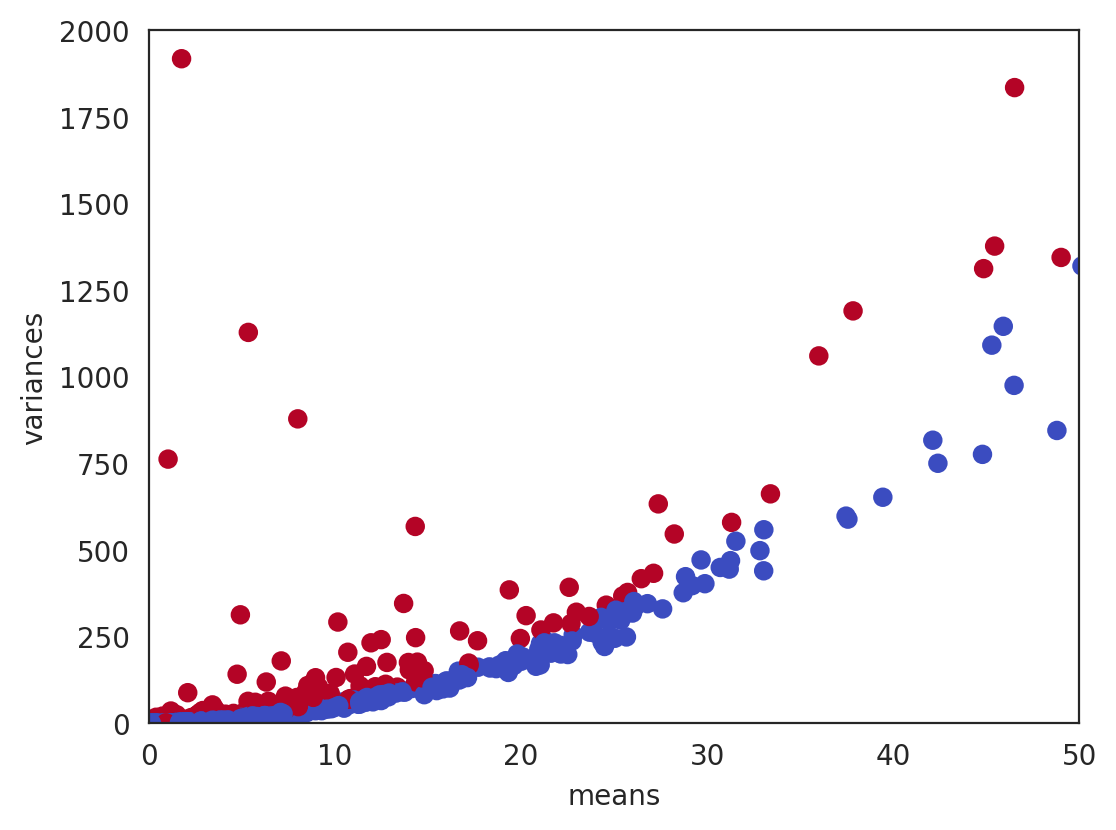

In [95]:
plt.scatter(expression_quantified.var["means"], 
            expression_quantified.var["variances"], 
            c=expression_quantified.var["highly_variable"],
            cmap="coolwarm")
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [96]:
presence = pd.Series(data=np.zeros_like(expression_quantified.var["means"]), 
                     index=expression_quantified.var.index)
for gene in list(obs_genes.keys()):
    presence[gene] += 1
expression_quantified.var["targeted"] = presence

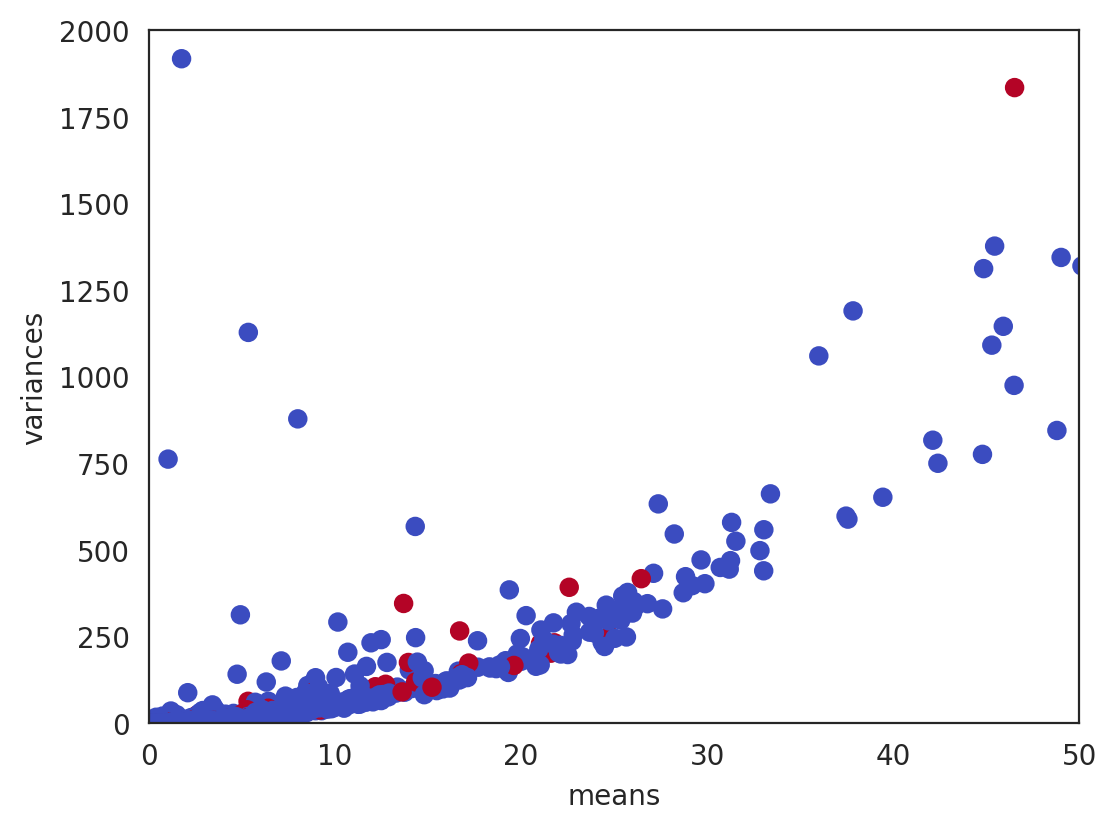

In [97]:
plt.scatter(expression_quantified.var["means"], 
            expression_quantified.var["variances"], 
            c=expression_quantified.var["targeted"], 
            cmap="coolwarm")
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [98]:
(expression_quantified.var["highly_variable"] * expression_quantified.var["targeted"]).sum()

98.0

In [99]:
to_keep = np.logical_or(expression_quantified.var["highly_variable_rank"] < 1500, expression_quantified.var["targeted"])
expression_quantified_gf = expression_quantified[:, to_keep].copy()

In [104]:
expression_quantified_gf

AnnData object with n_obs × n_vars = 218027 × 1657
    obs: 'Cell', 'sgRNAs', 'NAME', 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'targets', 'perturbation', 'is_control', 'is_control_int', 'n_genes', 'regimes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'targeted'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Basic EDA

In [107]:
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified_gf, n_comps=100)
sc.pp.neighbors(expression_quantified_gf)
sc.tl.umap(expression_quantified_gf)
clusterResolutions = []
sc.tl.leiden(expression_quantified_gf)
cc_genes = pd.read_csv(cellCyclePath, header = None)[0]
sc.tl.score_genes_cell_cycle(expression_quantified_gf, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])

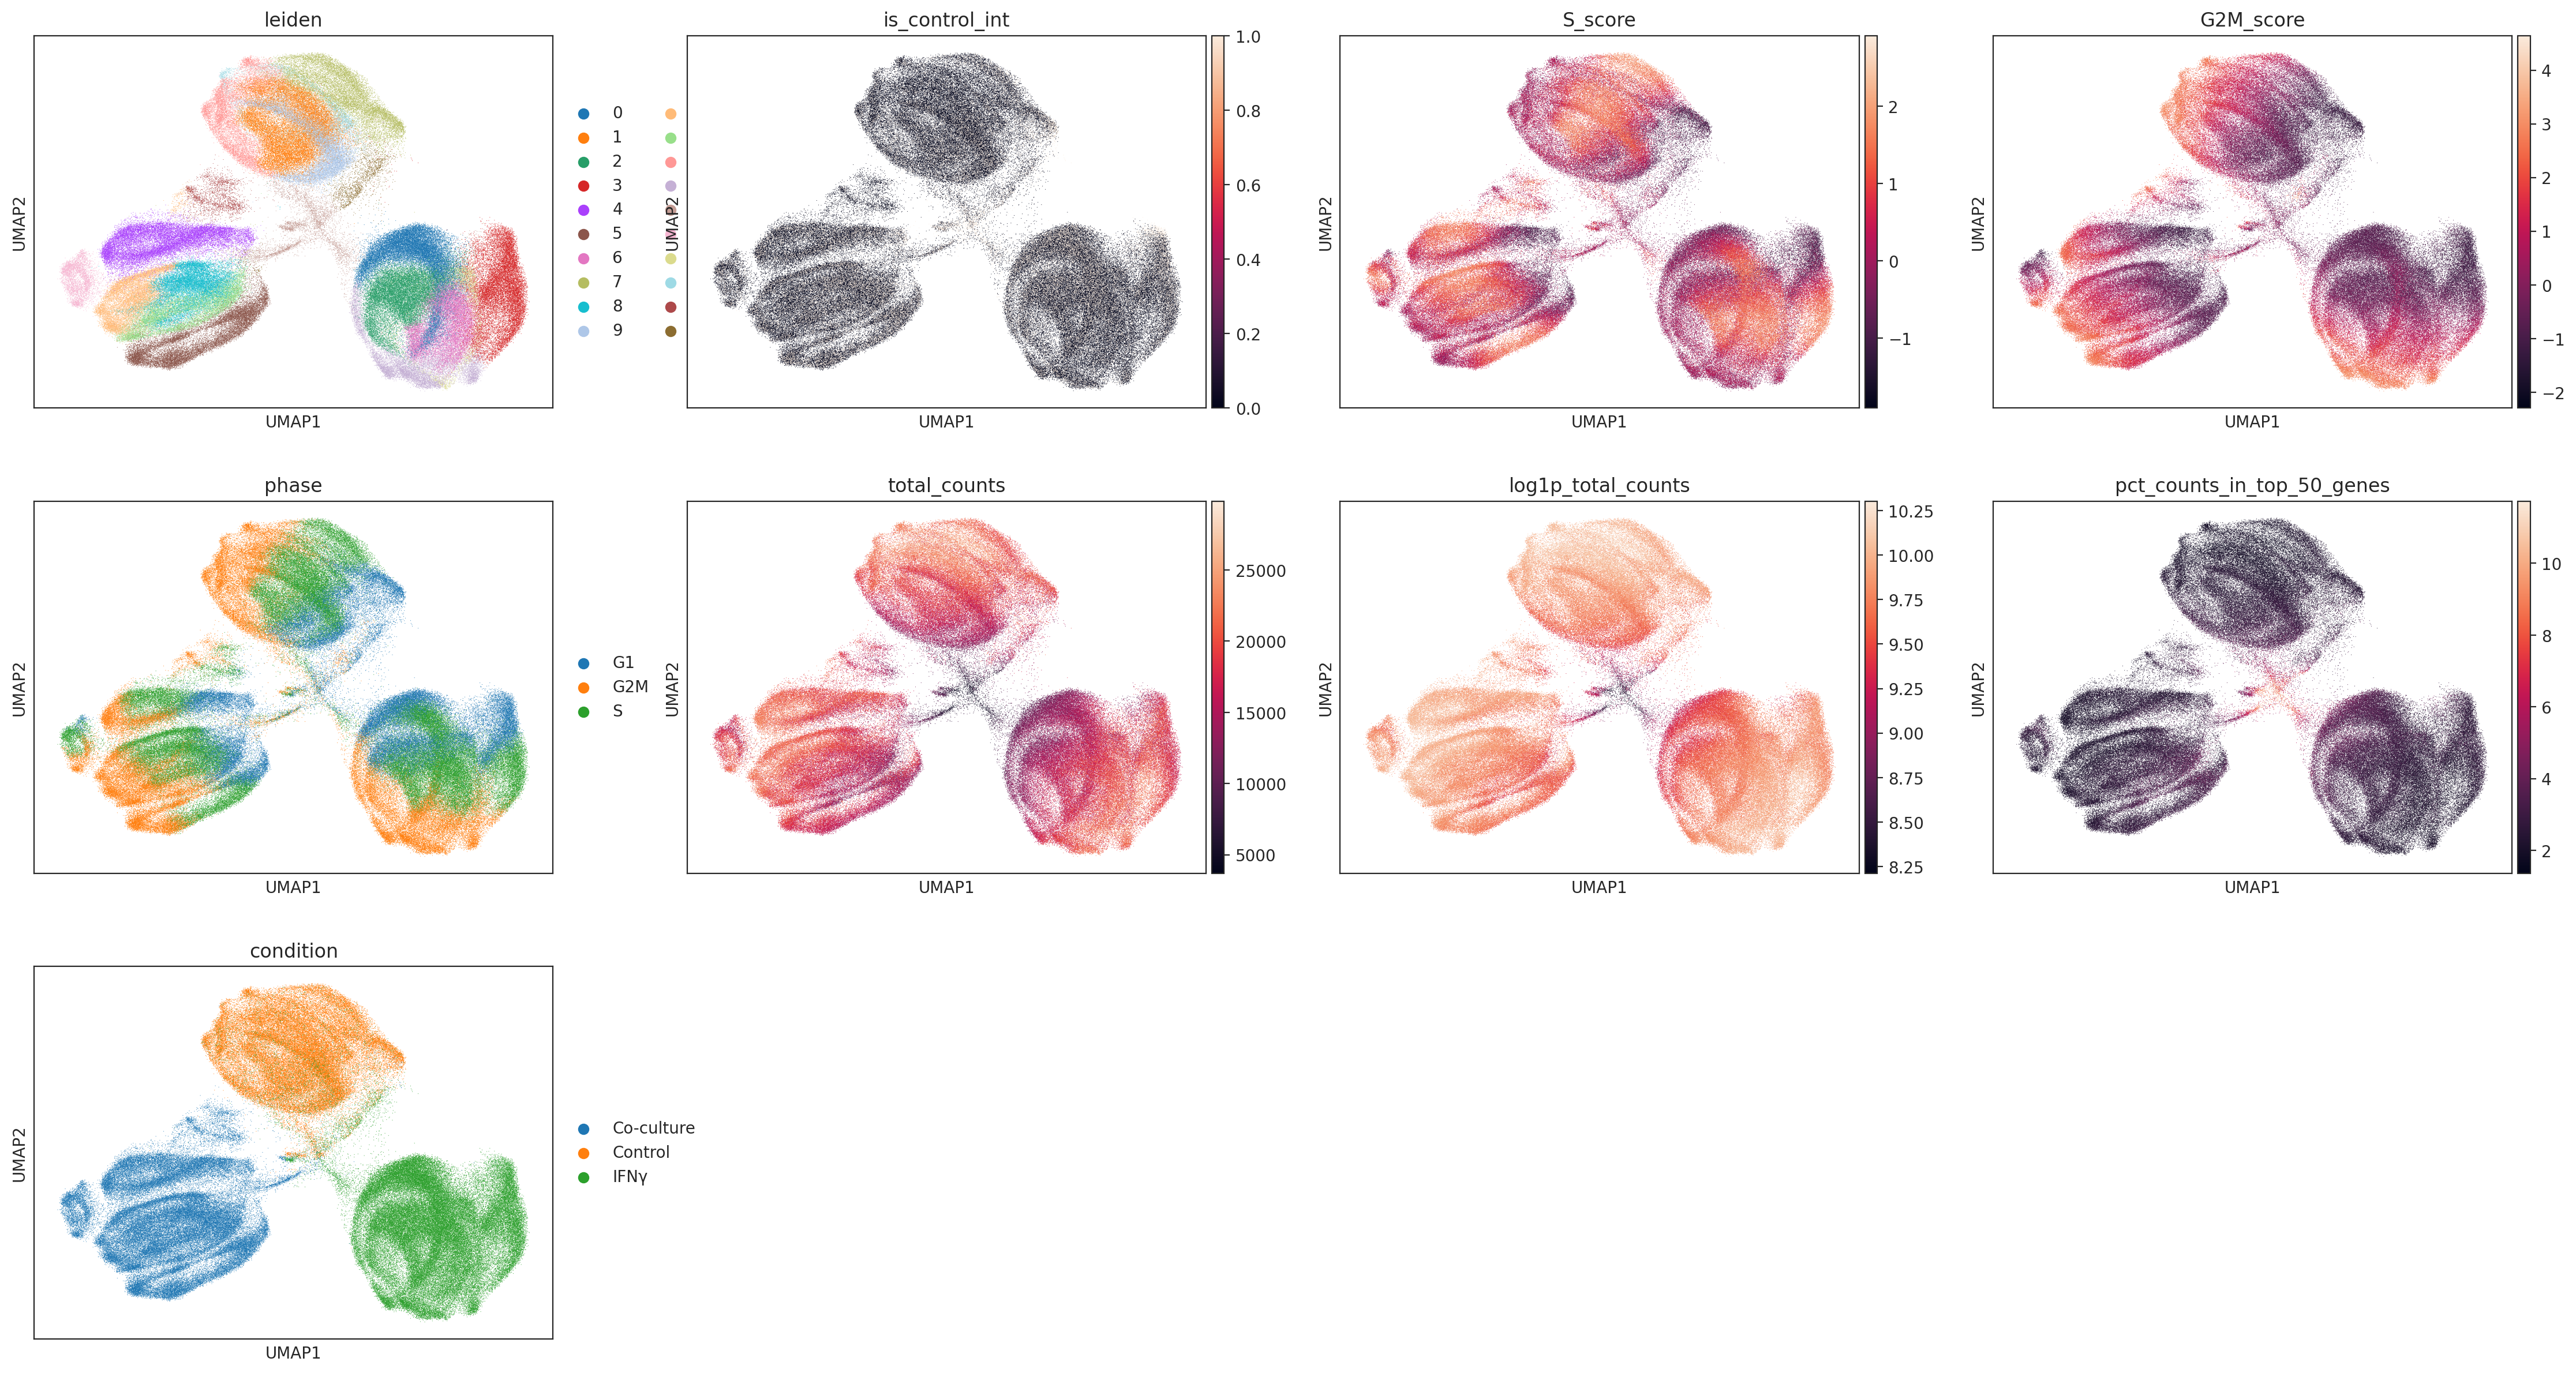

In [109]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(expression_quantified_gf, color = [
    "leiden", 
    "is_control_int",
    'S_score',
    'G2M_score', 
    'phase', 
    'total_counts', 
    'log1p_total_counts',
    'pct_counts_in_top_50_genes', 
    'condition'
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified_gf.obs["fake_cluster"]="all_one_cluster"
expression_quantified_gf.obs.fake_cluster = expression_quantified_gf.obs.fake_cluster.astype("category")
expression_quantified_gf.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [119]:
tmp = [t.split(',') for t in targets if t]
targets = set([i for j in tmp for i in j])

In [122]:
print("These genes were perturbed:")
print(targets)
print("These genes were perturbed but not measured:")
print(unfound_genes)
print("This many variable genes will be kept and used by CO:")
print(len(expression_quantified_gf.var_names))

These genes were perturbed:
{'CTSA', 'RTP4', 'HLA-C', 'LGALS3', 'SNRPG', 'ATP1B1', 'ATP5MD', 'SLC19A1', 'SLC26A2', 'IDH2', 'FKBP4', 'TIMP2', 'GSEC', 'PSMB8-AS1', 'SPESP1', 'FBXO32', 'RB1', 'MYC', 'LAMP2', 'CTSD', 'EIF3K', 'UQCRFS1', 'NDUFA13', 'HNRNPC', 'C6orf226', 'GAA', 'DDR1', 'UQCRH', 'ISYNA1', 'SDCBP', 'SLC5A3', 'CYP27A1', 'FARSA', 'FMN1', 'P2RX4', 'SINHCAF', 'LRPAP1', 'PRELID3B', 'SDC3', 'DAG1', 'DLL3', 'AEBP1', 'TP53', 'MFGE8', 'CTSL', 'NME1', 'SEC11C', 'EVA1A', 'PAICS', 'GRN', 'TIMP3', 'TPP1', 'CITED1', 'DDX39A', 'STX7', 'RACK1', 'STAT1', 'NPC2', 'CD63', 'CCR10', 'NPC1', 'AHCY', 'ACSL3', 'FBL', 'PSMA7', 'NACA', 'TAPBPL', 'NCL', 'CD58', 'IFNGR1', 'TM4SF1', 'UBL5', 'CD151', 'CTSB', 'PYGB', 'MIA', 'CDKN2B', 'DNMT1', 'HLA-DRB5', 'RPSA', 'RAB27A', 'LY96', 'HLA-B', 'SOX4', 'POLD2', 'SERPINE2', 'UBA52', 'CGAS', 'TMEM173', 'FRZB', 'HLA-F', 'E2F1', 'MDH2', 'PPIA', 'MRPL47', 'CDK4', 'CD274', 'ARMC6', 'CORO1A', 'CDKN1A', 'TXNDC17', 'HLA-E', 'TRIM22', 'GPI', 'SNRPF', 'STOM', 'KDR', 'NT5E',

In [124]:
# final form, ready to save
expression_quantified_gf.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified_gf.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
expression_quantified_gf.uns["perturbations_overlap"] = True
expression_quantified_gf.obs["perturbation_type"] = "knockout" 
expression_quantified_gf.obs["expression_level_after_perturbation"] = 0 

In [127]:
expression_quantified_gf.obs["spearmanCorr"] = 0
expression_quantified_gf.obs["pearsonCorr"] = 0

In [ ]:
os.makedirs(finalDataFileFolder, exist_ok = True)
expression_quantified_gf.write_h5ad(finalDataFilePath)